# Prob of Emergence for Mask Model


$P(\text{Node wears mask}) = m$


$E_{L, 0}$ := The probability of extinction at level $L$ node wear masks


$E_{L, 1}$ := The probability of extinction at level $L$ no mask



## 1. Condition on num of neighbors


$B_k$ := Node v has $k - 1$ lower level neighbors

$P(E_{L, i}) = \sum_{k = 1}^{\infty}{P(E_{L, i} | B_k) * P(B_k)}$


$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$

## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(E_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(E_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of infections

$I_0$ := $I_0$ of $n$ lower level neighbors who wear masks are active

$I_1$ := $I_1$ of $k-1-n$ lower level neighbors who don't wear masks are active

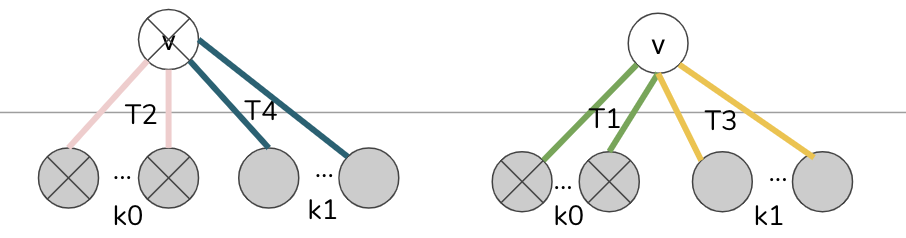

### Inital infective wears a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_2)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_4)\right)$


$P(E_{L, 0} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_4 ^{k_1} * (1 - T_4)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_2 ^{k_0} * (1 - T_2)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_4 ^{k_1} * (1 - T_4)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$
 
--- 

### Inital infective doesn't wear a mask

$I_0 \sim \operatorname{Binomial}\left(n, T_1)\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, T_3)\right)$


$P(E_{L, 1} | B_k, N = n) $

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}P(E_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_1 ^{k_0} * (1 - T_1)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1}$

$= \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k - 1 - n}\left(\begin{array}{c}
n \\
k_0
\end{array}\right)  * T_1 ^{k_0} * (1 - T_1)^{n - k_0} * \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * T_3 ^{k_1} * (1 - T_3)^{k - 1 - n - k_1} * P(E_{L,0})^{k_0} * P(E_{L, 1})^{k_1}$

In [1]:
from __future__ import division
import argparse
import math
import sys

import numpy as np
from scipy.optimize import fsolve
from scipy.special import comb
from scipy.stats import poisson
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.misc
from scipy import linalg as LA

def PE(i, E0, E1, T_list, m, mean_degree):
    res = 0
    for k in range(0, max_degree):
        prob_r = poisson.pmf(k, mean_degree)
        pb = prob_r * k * 1.0 / mean_degree 
        res += pb * PE_B(i, k, E0, E1, T_list, m)
    return res

def PE_B(i, k, E0, E1, T_list, m):
    res = 0
    one_minus_m = 1 - m
    for n in range(k):
        pe_bn = PE_BN(i, n, k, E0, E1, T_list, m)
        res += pe_bn * comb(k - 1, n) * (m ** n) * (one_minus_m ** (k - 1 - n))
    return res

def PE_BN(i, n, k, E0, E1, T_list, m):
    T1 = T_list[0]
    T2 = T_list[1]
    T3 = T_list[2]
    T4 = T_list[3]
    
    res = 0 
    
    if i == 0:
        t_mask = T2
        t_no_mask = T4
    else:
        t_mask = T1
        t_no_mask = T3
    
    one_minus_mask = 1 - t_mask
    one_minus_no_mask = 1 - t_no_mask
        
        
    for k0 in range(n + 1):
        for k1 in range(k - n):
            res += comb(n, k0) * (t_mask ** k0) * (one_minus_mask ** (n - k0)) *\
            comb(k - 1 - n, k1) * (t_no_mask ** k1) * (one_minus_no_mask ** (k - 1 - n - k1)) *\
            (E0 ** k0) * (E1 ** k1)
            
    return res

def generate_new_transmissibilities_mask(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}

#     print("T1: %.5f" %T1)
#     print("T2: %.5f" %T2)
#     print("T3: %.5f" %T3)
#     print("T4: %.5f" %T4)
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask, T, m):
    roundN = 5 # Round T to roundN digits
    T1 = round(T * T_mask * T_mask * m, roundN)
    T2 = round(T * T_mask * (1 - m), roundN)
    T3 = round(T * (1 - m), roundN)
    T4 = round(T * T_mask * m , roundN)

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21,}

    print("Q1: %.5f" %Q1)
    print("Q2: %.5f" %Q2)
    
    print("T1: %.5f" %T1)
    print("T2: %.5f" %T2)
    print("T3: %.5f" %T3)
    print("T4: %.5f" %T4)

    print("mu11: %.5f" %mu11)
    print("mu12: %.5f" %mu12)
    print("mu22: %.5f" %mu22)
    print("mu21: %.5f" %mu21)
    return trans_dict, mu_dict

def PE_vec(mean_degree, T_list, m, E0, E1):
    E0 = PE(0, E0, E1, T_list, m, mean_degree)
    E1 = PE(1, E0, E1, T_list, m, mean_degree)
    return [E0, E1]

def func_root(E, mean_degree, T_list, m):
    return np.array(PE_vec(mean_degree, T_list, m, E[0], E[1]) - np.array(E))

def get_ProbEmergence(mean_degree, nodeN, T_list, m):
    
    E0, E1 = fsolve(func_root, (0.01, 0.01), args=(mean_degree, T_list, m), xtol=1e-6)
    
    
    pe_0 = 0
    pe_1 = 0
    
    T1 = T_list[0]
    T2 = T_list[1]
    T3 = T_list[2]
    T4 = T_list[3]
    
    one_minus_T1 = 1 - T1
    one_minus_T2 = 1 - T2
    one_minus_T3 = 1 - T3
    one_minus_T4 = 1 - T4
    
    one_minus_m = 1 - m
    
    for k in range(0, max_degree):
        prob_r = poisson.pmf(k, mean_degree)
        
        pe_b_0 = 0
        pe_b_1 = 0
        for n in range(k + 1):
            
            pe_bn_0 = 0
            pe_bn_1 = 0
            for k0 in range(n + 1):
                for k1 in range(k - n + 1):
                    pe_bn_0 += comb(n, k0) * (T2 ** k0) * (one_minus_T2 ** (n - k0)) *\
                    comb(k - n, k1) * (T4 ** k1) * (one_minus_T4 ** (k - n - k1)) *\
                    (E0 ** k0) * (E1 ** k1)

            
            for k0 in range(n + 1):
                for k1 in range(k - n + 1):
                    pe_bn_1 += comb(n, k0) * (T1 ** k0) * (one_minus_T1 ** (n - k0)) *\
                    comb(k - n, k1) * (T3 ** k1) * (one_minus_T3 ** (k - n - k1)) *\
                    (E0 ** k0) * (E1 ** k1)
            
            pe_b_0 += pe_bn_0 * comb(k , n) * (m ** n) * (one_minus_m ** (k - n))
            pe_b_1 += pe_bn_1 * comb(k , n) * (m ** n) * (one_minus_m ** (k - n))
        
        pe_0 += prob_r * pe_b_0
        pe_1 += prob_r * pe_b_1
    
        
        return 1 - np.array([pe_0, pe_1])

# Solve the equation

In [8]:
T_list

[0.09, 0.12, 0.24, 0.18]

In [2]:
"""
Parameters setup.
"""
T_mask = 0.5 # Impact of the mask
T = 0.6 # Original virus transmissiblity
m = 0.6 # P(people wear mask)
nodeN = 200000


dict_M = generate_new_transmissibilities_mask(T_mask, T, m)

T_list = list(generate_new_transmissibilities_mask(T_mask, T, m).values())

degree_min = 0
degree_max = 20

mean_degree_list = np.linspace(degree_min, degree_max, 50)

max_degree = 2 * degree_max # degree_inf

# h_r_1, h_r_2 = fsolve(func_root, (0.01, 0.01), args=(5, T_list, m), xtol=1e-6)

In [4]:
pe_0_list = []
pe_1_list = []
pe_list = []

for mean_degree in mean_degree_list:
    print("Mean degree:", mean_degree)
    E_0_1 = get_ProbEmergence(mean_degree, nodeN, T_list, m)
    pe_list.append(E_0_1[0] * m + E_0_1[1] * (1 - m))
    pe_0_list.append(E_0_1[0])
    pe_1_list.append(E_0_1[1])

Mean degree: 0.0


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Mean degree: 0.40816326530612246
Mean degree: 0.8163265306122449
Mean degree: 1.2244897959183674
Mean degree: 1.6326530612244898
Mean degree: 2.0408163265306123
Mean degree: 2.4489795918367347
Mean degree: 2.857142857142857
Mean degree: 3.2653061224489797
Mean degree: 3.673469387755102
Mean degree: 4.081632653061225
Mean degree: 4.4897959183673475
Mean degree: 4.8979591836734695
Mean degree: 5.3061224489795915
Mean degree: 5.714285714285714
Mean degree: 6.122448979591837
Mean degree: 6.530612244897959
Mean degree: 6.938775510204081
Mean degree: 7.346938775510204
Mean degree: 7.755102040816327
Mean degree: 8.16326530612245
Mean degree: 8.571428571428571
Mean degree: 8.979591836734695
Mean degree: 9.387755102040817
Mean degree: 9.795918367346939
Mean degree: 10.204081632653061
Mean degree: 10.612244897959183
Mean degree: 11.020408163265307
Mean degree: 11.428571428571429
Mean degree: 11.83673469387755
Mean degree: 12.244897959183675
Mean degree: 12.653061224489797
Mean degree: 13.0612244

Text(0.5, 1.0, 'Theoratical Prob of Emergence for Mask Model')

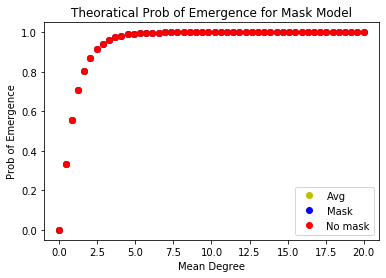

In [7]:
plt.figure()
plt.plot(mean_degree_list, pe_list, 'yo')
plt.plot(mean_degree_list, pe_0_list, 'bo')
plt.plot(mean_degree_list, pe_1_list, 'ro')

plt.xlabel("Mean Degree")
plt.ylabel("Prob of Emergence")
title = "Theoratical Prob of Emergence for Mask Model"
plt.legend(["Avg", "Mask", "No mask"])
plt.title(title)